In [ ]:
#Add cuda toolkit
import os
os.environ['CUDA_HOME'] = "/usr/local/cuda"

In [ ]:
#Update numba package
!pip install --upgrade numba

     |████████████████████████████████| 3.2MB 12.2MB/s 
     |████████████████████████████████| 25.3MB 116kB/s 
  Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0


In [ ]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Parallel Implementation

In [ ]:
#Kernel function
@cuda.jit
def rotation(image, rotatedImage, rotationType):
  thread_x, thread_y = cuda.grid(2)
  if thread_x < image.shape[0] and thread_y < image.shape[1]:
    #90 degree rotation
    if rotationType == 0:
      rotatedImage[image.shape[1] - thread_y][image.shape[0] - thread_x][0] = image[thread_x][thread_y][0]
      rotatedImage[image.shape[1] - thread_y][image.shape[0] - thread_x][1] = image[thread_x][thread_y][1]
      rotatedImage[image.shape[1] - thread_y][image.shape[0] - thread_x][2] = image[thread_x][thread_y][2]

    #180 degree rotation
    elif rotationType == 1:
      rotatedImage[image.shape[0] - thread_x][image.shape[1] - thread_y][0] = image[thread_x][thread_y][0]
      rotatedImage[image.shape[0] - thread_x][image.shape[1] - thread_y][1] = image[thread_x][thread_y][1]
      rotatedImage[image.shape[0] - thread_x][image.shape[1] - thread_y][2] = image[thread_x][thread_y][2]

    #270 degree rotation
    elif rotationType == 2:
      rotatedImage[image.shape[1] - thread_y][thread_x][0] = image[thread_x][thread_y][0]
      rotatedImage[image.shape[1] - thread_y][thread_x][1] = image[thread_x][thread_y][1]
      rotatedImage[image.shape[1] - thread_y][thread_x][2] = image[thread_x][thread_y][2]

#Image Rotation using Unified GPU Memory Management

##Code

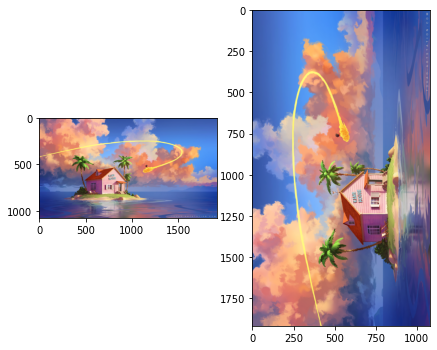

In [ ]:
#Import the image
image = cv2.imread("1080p_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Select the type of rotation
#0 is 90 degrees, 1 is 180 degrees, 2 is 270 degrees
rot = 2

#Check shape of original image
rows, cols, depth = image.shape

#Based on rotation type create the new image
if rot == 1:
  rotatedImage = np.zeros((rows, cols, depth))
elif rot == 0 or rot == 2:
  rotatedImage = np.zeros((cols, rows, depth))

#Setup grid size and thread count
grid_size = image.shape[:2]
thread_no = (1, 1)

#Call the kernel
rotation[grid_size, thread_no](image, rotatedImage, rot)

#Plot the rotations
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(rotatedImage.astype('uint8'))

plt.show()

##Timing

In [ ]:
print("Timing our rotation.")
for i in [2**x for x in range(6)]:
    grid_size = ((image.shape[0] + i )// i, (image.shape[1] + i) // i)
    thread_no = (i, i)
    print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
    %timeit rotation[grid_size, thread_no](image, rotatedImage, rot)

print()
print("Timing cv2 rotation.")
if rot == 0:
  %timeit cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

elif rot == 1:
  %timeit cv2.rotate(image, cv2.ROTATE_180)

elif rot == 2:
  %timeit cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

Timing our rotation.
Grid Size: (1081, 1921)
Threads Per Block: (1, 1)
10 loops, best of 3: 27.6 ms per loop
Grid Size: (541, 961)
Threads Per Block: (2, 2)
10 loops, best of 3: 26 ms per loop
Grid Size: (271, 481)
Threads Per Block: (4, 4)
10 loops, best of 3: 25.6 ms per loop
Grid Size: (136, 241)
Threads Per Block: (8, 8)
10 loops, best of 3: 25.8 ms per loop
Grid Size: (68, 121)
Threads Per Block: (16, 16)
10 loops, best of 3: 25.8 ms per loop
Grid Size: (34, 61)
Threads Per Block: (32, 32)
10 loops, best of 3: 26.4 ms per loop

Timing cv2 rotation.
100 loops, best of 3: 3.56 ms per loop


#Image Rotation using Explicit GPU Memory Management

##Code

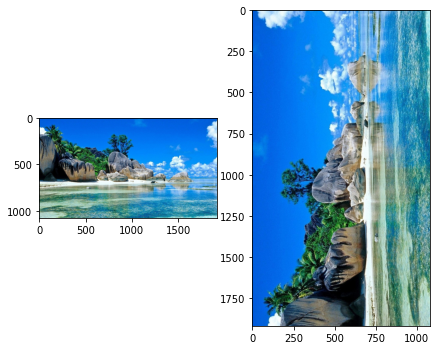

In [ ]:
#Import the image
image = cv2.imread("1080p_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Select the type of rotation
#0 is 90 degrees, 1 is 180 degrees, 2 is 270 degrees
rot = 2

#Check shape of original image
rows, cols, depth = image.shape

#Based on rotation type create the new image
if rot == 1:
  rotatedImage = np.zeros((rows, cols, depth))
elif rot == 0 or rot == 2:
  rotatedImage = np.zeros((cols, rows, depth))

#Setup grid size and thread count
grid_size = image.shape[:2]
thread_no = (1, 1)

#Pass information to GPU
d_image = cuda.to_device(image)
d_rotatedImage = cuda.to_device(rotatedImage)

#Call Kernel
rotation[grid_size, thread_no](d_image, d_rotatedImage, rot)

#Transfer data back to gpu
d_rotatedImage.copy_to_host(rotatedImage)

#Plot the rotations
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(rotatedImage.astype('uint8'))

plt.show()

##Timing

In [ ]:
d_image = cuda.to_device(image)
d_rotatedImage = cuda.to_device(rotatedImage)

print("Timing our rotation.")
for i in [2**x for x in range(6)]:
    grid_size = ((image.shape[0] + i )// i, (image.shape[1] + i) // i)
    thread_no = (i, i)
    print(f"Grid Size: ({grid_size[0]}, {grid_size[1]})\nThreads Per Block: ({i}, {i})")
    %timeit rotation[grid_size, thread_no](d_image, d_rotatedImage, rot)

print()
print("Timing cv2 rotation.")
if rot == 0:
  %timeit cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

elif rot == 1:
  %timeit cv2.rotate(image, cv2.ROTATE_180)

elif rot == 2:
  %timeit cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

Timing our rotation.
Grid Size: (1081, 1921)
Threads Per Block: (1, 1)
1000 loops, best of 3: 2.58 ms per loop
Grid Size: (541, 961)
Threads Per Block: (2, 2)
100 loops, best of 3: 2.6 ms per loop
Grid Size: (271, 481)
Threads Per Block: (4, 4)
100 loops, best of 3: 2.61 ms per loop
Grid Size: (136, 241)
Threads Per Block: (8, 8)
100 loops, best of 3: 834 µs per loop
Grid Size: (68, 121)
Threads Per Block: (16, 16)
1000 loops, best of 3: 464 µs per loop
Grid Size: (34, 61)
Threads Per Block: (32, 32)
1000 loops, best of 3: 451 µs per loop

Timing cv2 rotation.
100 loops, best of 3: 3.66 ms per loop
